In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class scaledDotProduct(nn.Module):
    '''
        Attention(Q, K, V ) = softmax( QK^T/√d_k)V 
    
    '''
    def __init__(self, dim, drop=0.0):
        super(scaledDotProduct, self).__init__()
        #dim is (d_k) when sqrt'd it is meant to counter small gradients in large sets of queries and keys
        self.d_k = np.sqrt(dim)
        #Simple drop out 
        self.drop = nn.Dropout(drop)

    def forward(self, q, k, v, mask=None):
        #first two dimensions are batch and number of heads?
        n = torch.matmul(q, k.transpose(2,3)) / self.d_k

        if mask != None:
            n = n.masked_fill_(mask==0, -1e9)
        #Drop out referenced later in paper but not in original diagram
        att = self.drop(F.softmax(n, -1))

        out = torch.matmul(n, v)

        return out, att 
        
        


In [3]:
#Scaled dot product attention testing
#dim should be size of q and k
scaled_dot = scaledDotProduct(3)
q = torch.rand(1,1,2,3)
k = torch.rand(1,1,2,3)
v = torch.rand(1,1,2,4)


scaled_dot(q,k,v)

(tensor([[[[0.6653, 0.4015, 0.5205, 0.6871],
           [0.7855, 0.4019, 0.5943, 0.8291]]]]),
 tensor([[[[0.4912, 0.5088],
           [0.5329, 0.4671]]]]))

In [4]:
class multiHeadedAttention(nn.Module):
    def __init__(self, n_heads, dims, d_k, d_v, dropout=0.0):
        super(multiHeadedAttention, self).__init__()
        #d_k=d_v = dims/h

        self.n_heads = n_heads
        self.d_k = d_k
        self.d_v = d_v
        #Pre-attention projection matrices
        self.w_q = nn.Linear(dims, n_heads * d_k, bias=False)
        self.w_k = nn.Linear(dims, n_heads * d_k, bias=False)
        self.w_v = nn.Linear(dims, n_heads * d_v, bias=False)

        self.att = scaledDotProduct(d_k)
        #Final linear layer after concat and attention
        self.fc = nn.Linear(n_heads*d_v, dims)

        self.drop = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(dims,eps=1e-6)

    def forward(self, q, k, v, mask=None):
        d_k, d_v, heads = self.d_k, self.d_v, self.n_heads
        batch_len, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

        res = q

        #Pass through projection layers prior to attention layer batch x length of query x (nheads x value dimensionality)
        #View as batches x len of query x numbers of heads x dimensionality to sperate out heads dimension
        #print(q.shape)
        q = self.w_q(q).view(batch_len, len_q, heads, d_k)
        k = self.w_k(k).view(batch_len, len_k, heads, d_k)
        v = self.w_v(v).view(batch_len, len_v, heads, d_v)


        #Transpose for attention
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)

        if mask != None:
            mask = mask.unsqueeze(1)

        q, attn = self.att(q, k, v, mask=mask)
        #Move head dim back - batch x len query x heads x dimensionality
        #Combined all heads into one - batch x len query x (heads x dimensionality)
        q = q.transpose(1,2).contiguous().view(batch_len, len_q, -1)
        q = self.drop(self.fc(q))
        q += res

        q = self.norm(q)

        return q, attn

        


In [5]:
#heads, d_model, d_km d_v as per the paper
multiHead = multiHeadedAttention(8, 512, 64, 64)
#batches, dims, dimensionalityxn_heads
q = torch.rand(1,512,512)
k = torch.rand(1,512,512)
v = torch.rand(1,512,512)


multiHead(q,k,v)

(tensor([[[ 1.4674, -0.3329,  0.5076,  ..., -0.1505, -0.0723, -1.0718],
          [ 0.1462, -0.0976,  0.4067,  ..., -0.0242, -1.0275, -0.5554],
          [ 1.1980, -0.3764,  0.9762,  ...,  0.6983, -0.3234, -0.8174],
          ...,
          [ 1.0814, -0.3805,  0.8375,  ..., -0.2045, -1.3006, -0.5733],
          [ 1.8049, -0.3260,  1.1032,  ..., -0.2787, -0.7653, -0.7527],
          [ 1.8185, -0.0852,  0.2948,  ..., -0.3116, -0.9810, -1.0676]]],
        grad_fn=<NativeLayerNormBackward0>),
 tensor([[[[0.0020, 0.0020, 0.0018,  ..., 0.0020, 0.0018, 0.0020],
           [0.0020, 0.0019, 0.0018,  ..., 0.0019, 0.0018, 0.0019],
           [0.0021, 0.0020, 0.0018,  ..., 0.0018, 0.0018, 0.0020],
           ...,
           [0.0020, 0.0019, 0.0019,  ..., 0.0018, 0.0019, 0.0021],
           [0.0020, 0.0019, 0.0017,  ..., 0.0020, 0.0019, 0.0019],
           [0.0021, 0.0019, 0.0017,  ..., 0.0019, 0.0018, 0.0020]],
 
          [[0.0020, 0.0019, 0.0019,  ..., 0.0020, 0.0020, 0.0020],
           [0.0020

In [6]:
class positionFeedFoward(nn.Module):
    def __init__(self, inp, hid, drop=0.0):
        super(positionFeedFoward, self).__init__()
        self.w1 = nn.Linear(inp,hid)
        self.w2 = nn.Linear(hid,inp)
        self.norm = nn.LayerNorm(inp, eps=1e-6)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        res = x

        x = self.w2(F.relu(self.w1(x)))
        x = self.drop(x)
        x += res
        x = self.norm(x)

        return x

In [7]:
class EncoderLayer(nn.Module):
    '''Combinds MultiHeadedAttention and FeedForward, two layers'''
    def __init__(self, dims, hid, nheads, d_k, d_v, drop=0.0):
        super(EncoderLayer, self).__init__()
        self.attn = multiHeadedAttention(nheads, dims,d_k, d_v, dropout=drop)
        self.ffn = positionFeedFoward(dims, hid, drop=drop)

    def forward(self, inp, mask=None):
        out, attn = self.attn(
            inp, inp, inp, mask
        )
        out = self.ffn(out)

        return out, attn
    
class DecoderLayer(nn.Module):
    '''Combinds MultiHeadedAttention and FeeForward, three layers'''
    def __init__(self, dims, hid, nheads, d_k, d_v, drop=0.0):
        super(DecoderLayer, self).__init__()
        self.slf_attn = multiHeadedAttention(nheads, dims,d_k, d_v, dropout=drop)
        self.enc_attn = multiHeadedAttention(nheads, dims,d_k, d_v, dropout=drop)
        self.ffn = positionFeedFoward(dims, hid, drop=drop)

    def forward(self, inp, enc_out, slf_mask, enc_mask=None):
        dec_out, dec_attn = self.slf_attn(
            inp, inp, inp, slf_mask
        )

        dec_out, enc_attn = self.enc_attn(
            dec_out, enc_out, enc_out, enc_mask
        )
        dec_out = self.ffn(dec_out)

        return dec_out, dec_attn, enc_attn

In [8]:
#heads, d_model, d_km d_v as per the paper
enc = EncoderLayer(512, 20, 8, 64, 64)
#batches, dims, dimensionalityxn_heads
q = torch.rand(1,512,512)
k = torch.rand(1,512,512)
v = torch.rand(1,512,512)


enc(v)

(tensor([[[-1.0902e+00,  1.0539e+00,  2.2613e+00,  ..., -1.5997e+00,
            5.8275e-02, -2.0548e-01],
          [-1.2093e-01, -1.8589e+00,  1.1843e+00,  ...,  1.1513e-01,
           -2.4805e-01,  9.4028e-01],
          [-4.3273e-01, -1.6249e+00,  7.8701e-01,  ..., -3.7283e-01,
            6.8029e-01, -8.4110e-01],
          ...,
          [ 9.3230e-03, -1.5287e+00,  1.5193e+00,  ..., -6.7035e-01,
           -1.2237e-01,  4.5052e-01],
          [-4.0632e-01, -1.8834e+00,  6.4183e-01,  ..., -5.9614e-01,
            1.9873e-01, -5.8356e-01],
          [ 3.7302e-02, -1.2359e+00,  1.5279e+00,  ..., -1.9549e+00,
            8.6905e-04, -7.1694e-01]]], grad_fn=<NativeLayerNormBackward0>),
 tensor([[[[0.0021, 0.0019, 0.0021,  ..., 0.0020, 0.0020, 0.0019],
           [0.0020, 0.0019, 0.0021,  ..., 0.0020, 0.0020, 0.0019],
           [0.0021, 0.0018, 0.0021,  ..., 0.0020, 0.0021, 0.0019],
           ...,
           [0.0022, 0.0019, 0.0021,  ..., 0.0019, 0.0019, 0.0019],
           [0.0021, 

In [9]:
#Pytoch version adapted from here https://pub.aimind.so/creating-sinusoidal-positional-embedding-from-scratch-in-pytorch-98c49e153d6
class PosEncoding(nn.Module):
    def __init__(self, hid, n_pos=200):
        super(PosEncoding, self).__init__()

        self.register_buffer('pos_table', self._get_sinusoid_encoding_table(n_pos, hid))

    def _get_sinusoid_encoding_table(self, n_pos, hid):

        if hid %2 != 0:
            raise ValueError("Sinusoidal positional embedding cannot apply to odd token embedding dim={}".format(hid))
        
        positions = torch.arange(0,n_pos).unsqueeze_(1)
        embeds = torch.zeros(n_pos, hid)

        denom = torch.pow(10000, 2 * torch.arange(0, hid//2)/2)
        embeds[:, 0::2] = torch.sin(positions/denom)
        embeds[:, 1::2] = torch.cos(positions/denom)
        embeds = embeds.unsqueeze(0)

        return embeds
    
    def forward(self, x):
        return x + self.pos_table[:, :x.size(1)].clone().detach()




In [10]:
class Encoder(nn.Module):
    '''Encoder model'''
    def __init__(
            self, n_vocab, d_word, n_layers, n_head, d_k, d_v, dims, hid, pad, dropout=0.0, n_pos=200, scale_emb=False
    ):
        super(Encoder, self).__init__()

        self.word_emb = nn.Embedding(n_vocab, d_word, padding_idx=pad)
        self.pos_enc = PosEncoding(d_word, n_pos=n_pos)
        self.drop = nn.Dropout(p=dropout)
        self.stack = nn.ModuleList([
            EncoderLayer(dims, hid, n_head, d_k, d_v, drop=dropout)
            for _ in range(n_layers)
        ])
        self.layer_norm = nn.LayerNorm(dims, eps=1e-6)
        self.scale_emb = scale_emb
        self.dims = dims

    def forward(self, seq, mask, ret_attns=False):
        enc_slf_attn_list = []

        enc_out = self.word_emb(seq)
        if self.scale_emb:
            enc_out *= self.dims ** 0.5
        enc_out = self.pos_enc(enc_out)
        enc_out = self.drop(enc_out)
        enc_out = self.layer_norm(enc_out)

        for enc_layer in self.stack:
            enc_out, enc_slf_attn = enc_layer(enc_out, mask=mask)
            enc_slf_attn_list += [enc_slf_attn] if ret_attns else []

        #if ret_attns:
            #return enc_out, enc_slf_attn_list
        return enc_out, enc_slf_attn_list

class Decoder(nn.Module):
    '''Decoder model'''
    def __init__(
            self, n_vocab, d_word, n_layers, n_head, d_k, d_v, dims, hid, pad, dropout=0.0 , n_pos=200, scale_emb=False
    ):
        super(Decoder, self).__init__()

        self.word_emb = nn.Embedding(n_vocab, d_word, padding_idx=pad)
        self.pos_enc = PosEncoding(d_word, n_pos=n_pos)
        self.drop = nn.Dropout(p=dropout)
        self.stack = nn.ModuleList([
            DecoderLayer(dims, hid, n_head, d_k, d_v, drop=dropout)
            for _ in range(n_layers)
        ])
        self.layer_norm = nn.LayerNorm(dims, eps=1e-6)
        self.scale_emb = scale_emb
        self.dims = dims

    def forward(self, seq, mask, enc_out, src_mask, ret_attns=False):
        dec_slf_attn_list, dec_enc_attn_list = [],[]

        dec_out = self.word_emb(seq)
        if self.scale_emb:
            dec_out *= self.dims ** 0.5
        dec_out = self.pos_enc(dec_out)
        dec_out = self.drop(dec_out)
        dec_out = self.layer_norm(dec_out)

        for dec_layer in self.stack:
            dec_out, dec_self_attn, dec_enc_attn = dec_layer(
                dec_out, enc_out, slf_mask=mask, enc_mask=src_mask
            )
            dec_slf_attn_list += [dec_self_attn] if ret_attns else []
            dec_enc_attn_list += [dec_enc_attn] if ret_attns else []

        #if ret_attns:
            #return dec_out, dec_slf_attn_list, dec_enc_attn_list
        return dec_out, dec_slf_attn_list, dec_enc_attn_list



In [11]:
def get_pad_mask(seq, pad_idx):
    return (seq != pad_idx).unsqueeze(-2)

def get_subsequent_mask(seq):
    ''' For masking out the subsequent info. '''
    len_s = seq.size(-1)
    subsequent_mask = (1 - torch.triu(
        torch.ones((1, len_s, len_s), device=seq.device), diagonal=1)).bool()
    return subsequent_mask

In [12]:
class Transformer(nn.Module):
    '''Attempt at recreating the sequence to sequence model'''
    def __init__(
            self, src_vocab, trg_vocab, src_pad, trg_pad, d_word=512, dims=512, hid=2048, n_layers=6, n_heads=8, d_k=64, d_v=64, drop=0.0, n_pos=200, trg_emb_prj_weight_sharing=True, emb_src_trg_weight_sharing=True, scale_emb_or_prj='prj'
    ):
        super(Transformer, self).__init__()

        self.src_pad, self.trg_pad = src_pad, trg_pad

        assert scale_emb_or_prj in ['emb', 'prj', 'none']
        scale_emb = (scale_emb_or_prj=='emb') if trg_emb_prj_weight_sharing else False
        self.scale_prj = (scale_emb_or_prj == 'prj') if trg_emb_prj_weight_sharing else False
        self.dims = dims

        self.encoder = Encoder(
            n_vocab=src_vocab, n_pos=n_pos,
            d_word=d_word, dims=dims, hid=hid,
            n_layers=n_layers, n_head=n_heads, d_k=d_k, d_v=d_v,
            pad=src_pad, dropout=drop, scale_emb=scale_emb
        )

        self.decoder = Decoder(
            n_vocab=trg_vocab, n_pos=n_pos,
            d_word=d_word, dims=dims, hid=hid,
            n_layers=n_layers, n_head=n_heads, d_k=d_k, d_v=d_v,
            pad=trg_pad, dropout=drop, scale_emb=scale_emb
        )

        self.trg_word_prj = nn.Linear(dims, trg_vocab, bias=False)

        for j in self.parameters():
            if j.dim()>1:
                nn.init.xavier_uniform_(j)

        assert dims == d_word

        if trg_emb_prj_weight_sharing:
            self.trg_word_prj.weight = self.decoder.word_emb.weight

        if emb_src_trg_weight_sharing:
            self.encoder.word_emb.weight = self.decoder.word_emb.weight

    def forward(self, src_seq, trg_seq):
        src_mask = get_pad_mask(src_seq, self.src_pad)
        trg_mask = get_pad_mask(trg_seq, self.trg_pad) & get_subsequent_mask(trg_seq)

        enc_out, *_ = self.encoder(src_seq, src_mask)
        dec_out, *_ = self.decoder(trg_seq, trg_mask, enc_out, src_mask)
        seq_logit = self.trg_word_prj(dec_out)
        if self.scale_prj:
            seq_logit *= self.dims ** -0.5

        return seq_logit.view(-1, seq_logit.size(2))

In [13]:
#Text file containing english sentences
file_path = './raw_sentences.txt'

sentences = []
for line in open(file_path):
    words = line.split()
    sentence = [word.lower() for word in words]
    sentences.append(sentence)

vocab = set([w for s in sentences for w in s])

print(len(sentences)) # 97162
print(len(vocab))

97162
250


In [14]:
test, valid, train = sentences[:10000], sentences[10000:20000], sentences[20000:]

for i in range(10):
    print(train[i])

['last', 'night', ',', 'he', 'said', ',', 'did', 'it', 'for', 'me', '.']
['on', 'what', 'can', 'i', 'do', '?']
['now', 'where', 'does', 'it', 'go', '?']
['what', 'did', 'the', 'court', 'do', '?']
['but', 'at', 'the', 'same', 'time', ',', 'we', 'have', 'a', 'long', 'way', 'to', 'go', '.']
['that', 'was', 'the', 'only', 'way', '.']
['this', 'team', 'will', 'be', 'back', '.']
['so', 'that', 'is', 'what', 'i', 'do', '.']
['we', 'have', 'a', 'right', 'to', 'know', '.']
['now', 'they', 'are', 'three', '.']


In [15]:
count = Counter()
n=0
sum = 0
for n in range(len(sentences)):
    sum+=len(sentences[n])
    count.update(sentences[n])
print('avg: ' + str(sum/n))
print('unique: '+str(len(count)))
print('10 most common: ')
keys = sorted(count, key=count.get, reverse=True)[:10]
print(keys)
print("total words: ")
sum = 0
for val in list(count.values()):
    sum+=val
print(sum)
count_percent ={}
for key, val in list(count.items()):
    count_percent[key]=round((val/sum)*100,2)


print("Percentages")
print(count_percent)

avg: 7.792962196766192
unique: 250
10 most common: 
['.', 'it', ',', 'i', 'do', 'to', 'nt', '?', 'the', 'that']
total words: 
757172
Percentages
{'no': 0.46, ',': 3.25, 'he': 2.03, 'says': 0.13, 'now': 0.58, '.': 10.69, 'and': 1.22, 'what': 1.51, 'did': 1.12, 'do': 2.67, '?': 2.14, 'the': 2.11, 'money': 0.29, "'s": 2.08, 'there': 0.95, 'that': 2.09, 'was': 1.14, 'less': 0.04, 'than': 0.08, 'a': 0.94, 'year': 0.24, 'ago': 0.05, 'but': 1.26, 'made': 0.11, 'only': 0.18, 'first': 0.16, 'still': 0.22, 'time': 0.59, 'for': 0.68, 'them': 0.42, 'to': 2.58, 'it': 3.86, 'should': 0.26, 'nt': 2.17, 'have': 1.08, 'they': 1.41, 'come': 0.37, 'down': 0.1, 'people': 0.48, 'i': 2.94, 'know': 1.15, 'where': 0.34, 'is': 1.64, 'would': 0.47, 'who': 0.27, 'will': 0.48, 'be': 0.86, 'not': 1.3, 'one': 0.57, 'you': 1.69, 'could': 0.39, 'are': 1.08, 'place': 0.16, 'like': 0.6, 'of': 0.78, 'here': 0.44, 'so': 0.54, 'on': 0.35, 'or': 0.19, 'him': 0.26, 'both': 0.06, 'going': 0.6, 'get': 0.54, 'in': 0.61, 'my': 

In [16]:
vocab_itos = dict(enumerate(vocab))
# A mapping of word => its index
vocab_stoi = {word:index for index, word in vocab_itos.items()}

def convert_words_to_indices(sents):
    """
    This function takes a list of sentences (list of list of words)
    and returns a new list with the same structure, but where each word
    is replaced by its index in `vocab_stoi`.

    Example:
    >>> convert_words_to_indices([['one', 'in', 'five', 'are', 'over', 'here'],
                                  ['other', 'one', 'since', 'yesterday'],
                                  ['you']])
    [[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]]
    """
    sent_inds=[]
    for sent in sents:
        sent_ind = []
        for word in sent:
            sent_ind.append(vocab_stoi[word])
        sent_inds.append(sent_ind)
    return sent_inds

def generate_4grams(seqs):
    """
    This function takes a list of sentences (list of lists) and returns
    a new list containing the 4-grams (four consequentively occuring words)
    that appear in the sentences. Note that a unique 4-gram can appear multiple
    times, one per each time that the 4-gram appears in the data parameter `seqs`.

    Example:

    >>> generate_4grams([[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]])
    [[148, 98, 70, 23], [98, 70, 23, 154], [70, 23, 154, 89], [151, 148, 181, 246]]
    >>> generate_4grams([[1, 1, 1, 1, 1]])
    [[1, 1, 1, 1], [1, 1, 1, 1]]
    """

    fourgrams =[]
    for seq in seqs:
        while len(seq)>3:
            fourgrams.append(seq[:4])
            seq=seq[1:]
    return fourgrams

def process_data(sents):
    """
    This function takes a list of sentences (list of lists), and generates an
    numpy matrix with shape [N, 4] containing indices of words in 4-grams.
    """
    indices = convert_words_to_indices(sents)
    fourgrams = generate_4grams(indices)
    return np.array(fourgrams)

print(generate_4grams([[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]]))
train4grams = process_data(train)
valid4grams = process_data(valid)
test4grams = process_data(test)

[[148, 98, 70, 23], [98, 70, 23, 154], [70, 23, 154, 89], [151, 148, 181, 246]]


In [17]:
train4grams[0]

array([189, 166, 224,  92])

In [18]:
model = Transformer(
    len(vocab), len(vocab),  0,0, d_word=len(vocab), dims=len(vocab), n_heads=2,n_layers=2, n_pos=3
    ).to(device)



In [19]:
test_inp = torch.tensor(train4grams[:2]).to(device)
out = model(test_inp[:,:3], test_inp[:,-1].unsqueeze(1))
out

tensor([[-0.0202, -0.0673, -0.0181,  0.0371, -0.0456, -0.0875, -0.0023, -0.0348,
          0.0707,  0.1415, -0.0412, -0.0504,  0.1178, -0.0271, -0.0505, -0.0024,
          0.1159, -0.0013,  0.0119,  0.0021, -0.0470,  0.0302,  0.0010,  0.0559,
          0.0549, -0.0411, -0.0375,  0.0282,  0.0275, -0.0124,  0.0176,  0.0071,
         -0.0270, -0.0709,  0.0505,  0.0215, -0.0431,  0.0315, -0.0158,  0.0002,
         -0.0069,  0.0704,  0.0790, -0.0779,  0.0323,  0.0375,  0.0720, -0.0165,
         -0.0299, -0.0066, -0.0218,  0.0361, -0.1265, -0.0384,  0.0203,  0.0102,
         -0.0817, -0.0353,  0.0338, -0.0994, -0.1174,  0.0299, -0.0203,  0.0145,
         -0.0168, -0.0924, -0.0686,  0.0572,  0.0059, -0.0423, -0.1124, -0.0434,
         -0.1062, -0.0178,  0.0451,  0.0201, -0.0229, -0.0226,  0.0836, -0.0417,
          0.0021, -0.0079,  0.0574, -0.0081,  0.0954,  0.0120,  0.0631,  0.0543,
          0.0681,  0.0310, -0.0306,  0.0015,  0.1949,  0.0121, -0.0769, -0.0605,
         -0.1086, -0.0946, -

In [20]:
def estimate_accuracy_torch(model, data, batch_size=5000, max_N=100000):
    """
    Estimate the accuracy of the model on the data. To reduce
    computation time, use at most `max_N` elements of `data` to
    produce the estimate.
    """
    correct = 0
    N = 0
    for i in range(0, data.shape[0], batch_size):
        # get a batch of data
        xs, ts = data[i:i+batch_size,:3], data[i:i+batch_size,3]
        
        # forward pass prediction
        z = model(torch.Tensor(xs).long().to(device),torch.Tensor(xs).long().to(device))
        z = z.cpu().detach().numpy() # convert the PyTorch tensor => numpy array
        pred = np.argmax(z, axis=1)
        correct += np.sum(pred == ts)
        N += ts.shape[0]

        if N > max_N:
            break
    return correct / N

In [21]:
def train(model, train_data=train4grams, validation_data = valid4grams, batch_size=300, lr=0.003, weight_decay=0, max_iters=2500, checkpoint_path=None):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98))

    iters, losses = [], []
    iters_sub, train_accs, val_accs  = [], [] ,[]

    n = 1

    while True:
        for i in range(0, train_data.shape[0], batch_size):
            if (i + batch_size) > train_data.shape[0]:
                break
            xs, ts, trg = train_data[i:i+batch_size,:3], train_data[i:i+batch_size,3], train_data[i:i+batch_size, 2:]

            # convert from numpy arrays to PyTorch tensors
            xs = torch.Tensor(xs).long().to(device)
            ts = torch.Tensor(ts).long().to(device)
            trg = torch.Tensor(trg).long().to(device)

            zs = model(xs, ts.unsqueeze(1))[:batch_size]
            loss = criterion(zs, ts) # compute the total loss
            loss.backward()          # compute updates for each parameter
            optimizer.step()         # make the updates for each parameter
            optimizer.zero_grad()    # a clean up step for PyTorch

            for param_group in optimizer.param_groups:
                param_group['lr'] = 250**(-0.5) * min(n**(-0.5), n * 4000**(-1.5))

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)  # compute *average* loss

            if n % 500 == 0:
                iters_sub.append(n)
                train_cost = float(loss.cpu().detach().numpy())
                train_acc = estimate_accuracy_torch(model, train_data)
                train_accs.append(train_acc)
                val_acc = estimate_accuracy_torch(model, validation_data)
                val_accs.append(val_acc)
                print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (
                      n, val_acc * 100, train_acc * 100, train_cost))

                if (checkpoint_path is not None) and n > 0:
                    torch.save(model.state_dict(), checkpoint_path.format(n))

            # increment the iteration number
            n += 1

            if n > max_iters:
                return iters, losses, iters_sub, train_accs, val_accs



In [22]:
def plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs, label="Train")
    plt.plot(iters_sub, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

/tmp/ipykernel_16402/1689188816.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  correct += np.sum(pred == ts)


Iter 500. [Val Acc 0%] [Train Acc 0%, Loss 4.288957]
Iter 1000. [Val Acc 0%] [Train Acc 0%, Loss 2.932194]
Iter 1500. [Val Acc 0%] [Train Acc 0%, Loss 0.934764]
Iter 2000. [Val Acc 0%] [Train Acc 0%, Loss 0.135990]
Iter 2500. [Val Acc 0%] [Train Acc 0%, Loss 0.052443]
Iter 3000. [Val Acc 0%] [Train Acc 0%, Loss 0.000693]
Iter 3500. [Val Acc 0%] [Train Acc 0%, Loss 0.041228]


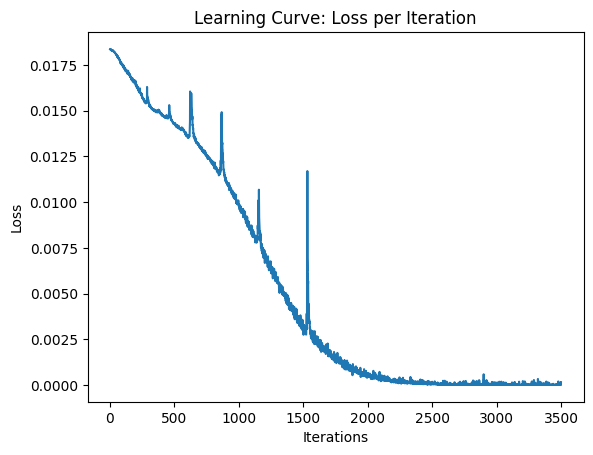

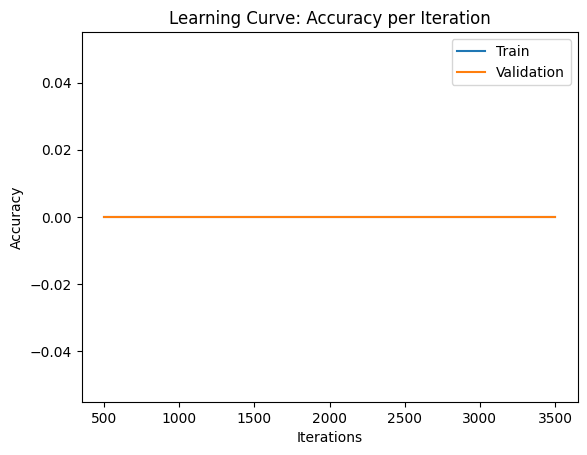

In [23]:
train_info = train(model, max_iters=3500)
plot_learning_curve(*train_info)

In [24]:
print(train4grams[0])
testinp = train4grams[0]
inp=torch.tensor(train4grams[0,:3]).to(device).unsqueeze(0)
out=torch.tensor([230]).to(device).unsqueeze(1)
print(inp)
print(out)
print(inp.shape)
print(out.shape)
modelout = model(inp, out)
print(modelout)
print(torch.argmax(modelout, dim=1))

[189 166 224  92]
tensor([[189, 166, 224]], device='cuda:0')
tensor([[230]], device='cuda:0')
torch.Size([1, 3])
torch.Size([1, 1])
tensor([[-3.1642e-01,  7.1208e-01, -1.0682e+00,  1.8379e-01, -7.6110e-02,
         -7.5699e-01, -4.2730e-01,  7.4626e-01,  3.6752e-01,  2.4639e+00,
         -1.9729e-01, -7.1045e-01,  3.3013e-01, -1.5433e+00,  7.7052e-01,
          7.7752e-01,  5.3833e-02,  1.1874e-01,  4.1776e-01,  2.3519e-01,
         -6.3361e-01,  1.3553e+00,  1.3513e+00, -7.5636e-01,  4.1051e-01,
         -4.1969e-01, -3.4614e-01,  1.4538e+00,  8.0089e-01,  2.4482e-01,
         -1.3869e+00, -1.8914e-01, -8.8416e-02,  3.7548e-01,  3.2961e-02,
         -2.7235e-01, -1.8070e-01, -2.5000e-02, -7.2730e-02, -9.8304e-01,
          5.6697e-01,  5.3887e-01, -5.3177e-01, -1.0937e+00,  1.2957e+00,
         -8.1316e-01, -5.3902e-01,  8.4299e-01, -1.5094e+00,  4.2915e-01,
         -1.5471e-01, -4.0590e-01,  9.1792e-02, -1.2989e+00, -2.1958e-01,
          2.5734e-03,  6.0112e-01, -5.5732e-01, -7.254